#### Week 17 Homework
##### Angela Spencer January 26, 2022

##### 1.	What is inductive reasoning? Deductive reasoning? Give an example of each, different from the examples given in class. 
- Using ONE of the following sources, complete the questions for only that source. 
    - Credit approval: https://archive.ics.uci.edu/ml/datasets/Statlog+%28Australian+Credit+Approval%29
    - Cardiac Arrhythmia: https://archive.ics.uci.edu/ml/datasets/Arrhythmia 
    - Abalone age: https://archive.ics.uci.edu/ml/datasets/Abalone - this one is a bit harder since it’s not binary like the others, but if you really want to master these concepts, you should pick this one. Use RMSE as a performance metric if you do this as regression. You should target a value of under 3.  

- Note: at least one of your models should have the most relevant performance metric above .90 . All performance metrics should be above .75 . You will partially be graded on model performance.

##### 2.	Preprocess your dataset. Indicate which steps worked and which didn’t. Include your thoughts on why certain steps worked and certain steps didn’t. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Lasso

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [2]:
#view names file to determine column names

with open('../Datasets/abalone.names') as names:
    print(names.read())

1. Title of Database: Abalone data

2. Sources:

   (a) Original owners of database:
	Marine Resources Division
	Marine Research Laboratories - Taroona
	Department of Primary Industry and Fisheries, Tasmania
	GPO Box 619F, Hobart, Tasmania 7001, Australia
	(contact: Warwick Nash +61 02 277277, wnash@dpi.tas.gov.au)

   (b) Donor of database:
	Sam Waugh (Sam.Waugh@cs.utas.edu.au)
	Department of Computer Science, University of Tasmania
	GPO Box 252C, Hobart, Tasmania 7001, Australia

   (c) Date received: December 1995


3. Past Usage:

   Sam Waugh (1995) "Extending and benchmarking Cascade-Correlation", PhD
   thesis, Computer Science Department, University of Tasmania.

   -- Test set performance (final 1044 examples, first 3133 used for training):
	24.86% Cascade-Correlation (no hidden nodes)
	26.25% Cascade-Correlation (5 hidden nodes)
	21.5%  C4.5
	 0.0%  Linear Discriminate Analysis
	 3.57% k=5 Nearest Neighbour
      (Problem encoded as a classification task)

   -- Data set samp

In [3]:
# convert .data file to dataframe with column names
col = ['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 
       'viscera_weight', 'shell_weight', 'rings']
abalone = pd.read_csv('../Datasets/abalone.data', names=col)
abalone.head()

sex  length  diameter  height  whole_weight  shucked_weight  viscera_weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   shell_weight  rings  
0         0.150     15  
1         0.070      7  
2         0.210      9  
3         0.155     10  
4         0.055      7

In [4]:
#null values have already been removed from this dataset
abalone.isnull().sum()

sex               0
length            0
diameter          0
height            0
whole_weight      0
shucked_weight    0
viscera_weight    0
shell_weight      0
rings             0
dtype: int64

In [5]:
#check dtypes, only 'sex' is a string object
abalone.dtypes

sex                object
length            float64
diameter          float64
height            float64
whole_weight      float64
shucked_weight    float64
viscera_weight    float64
shell_weight      float64
rings               int64
dtype: object

In [6]:
#convert 'sex' column to numberic type
print(abalone['sex'].value_counts())

#one hot encode sex values
abalone = pd.concat([abalone, pd.get_dummies(abalone['sex'], prefix='sex_')], axis=1)

#drop redundant sex column
abalone.drop('sex', axis=1, inplace=True)

abalone.head()

M    1528
I    1342
F    1307
Name: sex, dtype: int64


length  diameter  height  whole_weight  shucked_weight  viscera_weight  \
0   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   shell_weight  rings  sex__F  sex__I  sex__M  
0         0.150     15       0       0       1  
1         0.070      7       0       0       1  
2         0.210      9       1       0       0  
3         0.155     10       0       0       1  
4         0.055      7       0       1       0

In [7]:
#seperate feature and target variables
X = abalone.drop('rings', axis=1)
#X = abalone[['whole_weight']]
y = abalone['rings']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

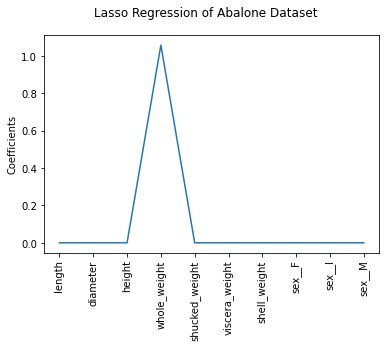

In [8]:
#Lasso regression to view the most highly correlated features

lasso = Lasso(alpha=0.6)

lasso_coef = lasso.fit(X,y).coef_
lasso_coef

X_labels = X.columns

n = plt.plot(range(len(X_labels)), lasso_coef)
n = plt.xticks(range(len(X_labels)), X_labels, rotation=90)
n = plt.ylabel('Coefficients')
n = plt.suptitle('Lasso Regression of Abalone Dataset')

plt.show()

#### 3.	Create a decision tree model tuned to the best of your abilities. Explain how you tuned it.

###### - Decision Tree Training Set

In [9]:
#instantiate and fit Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

#training set RMSE
rmse_dt_train = -cross_val_score(dt, 
                                 X_train, y_train, 
                                 cv=10, 
                                 scoring='neg_mean_squared_error', 
                                 n_jobs=-1)
rmse_dt_train = rmse_dt_train.mean()**(1/2)
print("Training Set RMSE of dt model: {:.2f}".format(rmse_dt_train))

Training Set RMSE of dt model: 3.06


###### - Decision Tree Testing Set

In [10]:
#predict target values from test set
y_pred_dt = dt.predict(X_test)

#check root mean squared error for accuracy
rmse_dt = (MSE(y_test, y_pred_dt))**(1/2)

print("Test RMSE of dt model: {:.2f}".format(rmse_dt))

Test RMSE of dt model: 2.89


###### - Decision Tree Testing Set w/ Parameter Tuning

In [11]:
#Grid Search CV to tune hyperparameters
params_dt = {'max_depth':[10,12,14,16], 
             'min_samples_leaf':[0.004, 0.2, 0.04, 0.08], 
             'max_features':[0.2, 0.5, 1]}

grid_dt = GridSearchCV(DecisionTreeRegressor(random_state=42), 
                       param_grid=params_dt, 
                       scoring='neg_mean_squared_error', 
                       cv=6)
grid_dt.fit(X_train, y_train)

#print best parameters
print('Best parameters from GridSearch CV: {:}'.format(grid_dt.best_params_))
print(' ')

#predict on test set with best estimator
y_pred_dt_tuned = grid_dt.best_estimator_.predict(X_test)

#RMSE of best estimator
rmse_dt_tuned = (MSE(y_test, y_pred_dt_tuned)**(1/2))

print('Test RMSE of tuned dt model: {:.2f}'.format(rmse_dt_tuned))

Best parameters from GridSearch CV: {'max_depth': 10, 'max_features': 0.5, 'min_samples_leaf': 0.004}
 
Test RMSE of tuned dt model: 2.37


#### 4.	Create a random forest model tuned to the best of your abilities. Explain how you tuned it.


###### - Random Forest Training Set

In [12]:
# instantiate RandomForestRegressor and fit to training set
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

#training set RMSE
rmse_rf_train = -cross_val_score(dt, 
                                 X_train, y_train, 
                                 cv=10, 
                                 scoring='neg_mean_squared_error', 
                                 n_jobs=-1)
rmse_rf_train = rmse_rf_train.mean()**(1/2)
print("Training Set RMSE of rf model: {:.2f}".format(rmse_rf_train))

Training Set RMSE of rf model: 3.06


###### - Random Forest Testing Set

In [13]:
#predict target values from test set
y_pred_rf = rf.predict(X_test)

#root mean squared error 
rmse_rf = (MSE(y_test, y_pred_rf)**(1/2))

print("Test RMSE of rf model: {:.2f}".format(rmse_rf))

Test RMSE of rf model: 2.19


###### - Decision Tree Testing Set w/ Parameter Tuning

###### - Random Forest RandomizedSearchCV

In [14]:
#create parameter grid for RandomizedSearchCV
param_dist = {'n_estimators':np.arange(100,400),
              'max_depth':np.arange(10,30), 
              'min_samples_leaf':np.arange(0.00001,0.001),
              'max_features':np.arange(0.1,1),
              'bootstrap':[True,False]}

#instantiate and fit 
random_rf = RandomizedSearchCV(rf, param_distributions = param_dist, n_iter = 20)

random_rf.fit(X_train, y_train)

#print best parameters from CV search
print('Best Parameters from RandomizedSearchCV:')
random_rf_params = random_rf.best_params_
random_rf_params

Best Parameters from RandomizedSearchCV:


{'n_estimators': 336,
 'min_samples_leaf': 1e-05,
 'max_features': 0.1,
 'max_depth': 19,
 'bootstrap': True}

In [15]:
# instantiate RandomForestRegressor with tuned parameters 
# fit to training set

rf_tuned = RandomForestRegressor(n_estimators=287, 
                                 min_samples_leaf=0.000001,
                                 max_features=0.1,
                                 max_depth=19,
                                 random_state=42,
                                 n_jobs=-1)

rf_tuned.fit(X_train, y_train)

#predict target values from test set
y_pred_rf_tuned = rf_tuned.predict(X_test)

#RMSE scoring
rmse_rf_tuned = (MSE(y_test, y_pred_rf_tuned)**(1/2))

print('Test RMSE of tuned rf model: {:.2f}'.format(rmse_rf_tuned))

Test RMSE of tuned rf model: 2.18


###### - Random Forest Grid Search CV

In [16]:
#Grid Search CV to tune hyperparameters

#set parameters grid
params_rf = {'n_estimators':[250,280,300], 
             'min_samples_leaf':[0.0000001, 0.0001, 0.001], 
             'max_features':[0.2, 0.5, 1], 
             'max_depth':[5,10,20]}

#instantiate and fit GridSearch to training set
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1), 
                       param_grid=params_rf, 
                       scoring='neg_mean_squared_error', 
                       cv=6)
grid_rf.fit(X_train, y_train)

#print best parameters
print('Best parameters from GridSearch CV: {:}'.format(grid_rf.best_params_))
print(' ')

#predict on test set with best estimator
y_pred_rf_tuned = grid_rf.best_estimator_.predict(X_test)

#RMSE of best estimator
rmse_rf_tuned = (MSE(y_test, y_pred_rf_tuned)**(1/2))

print('Test RMSE of tuned rf model: {:.2f}'.format(rmse_rf_tuned))

Best parameters from GridSearch CV: {'max_depth': 10, 'max_features': 0.5, 'min_samples_leaf': 0.001, 'n_estimators': 250}
 
Test RMSE of tuned rf model: 2.14


#### 5.	Create an xgboost model tuned to the best of your abilities. Explain how you tuned it. 

###### - XGBoost Training Set

In [17]:
#instantiate XGBRRegressor and fit to training set
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)

#training set RMSE
rmse_xgb_train = -cross_val_score(dt, 
                                 X_train, y_train, 
                                 cv=10, 
                                 scoring='neg_mean_squared_error', 
                                 n_jobs=-1)
rmse_xgb_train = rmse_xgb_train.mean()**(1/2)
print("Training Set RMSE of xgb model: {:.2f}".format(rmse_xgb_train))

Training Set RMSE of xgb model: 3.06


###### - XGBoost Testing Set

In [18]:
#predict target values useing the test set
y_pred_xgb = xgb.predict(X_test)

#calculate and print RMSE
rmse_xgb = (MSE(y_test, y_pred_xgb)**(1/2))

print("Test RMSE of xgb model: {:.2f}".format(rmse_xgb))

Test RMSE of xgb model: 2.29


###### - XGBoost Testing Set w/ Parameter Tuning

In [19]:
#Grid Search CV to tune hyperparameters
params_xgb = {'eta':[0.01, 0.3, 0.5], 
             'gamma':[0.01, 5, 30], 
             'max_depth':[3, 6, 15]}

grid_xgb = GridSearchCV(XGBRegressor(random_state=42), 
                       param_grid=params_xgb, 
                       scoring='neg_mean_squared_error', 
                       cv=6)
grid_xgb.fit(X_train, y_train)

#print best parameters
print('Best parameters from GridSearch CV: {:}'.format(grid_xgb.best_params_))
print(' ')

#predict on test set with best estimator
y_pred_xgb_tuned = grid_xgb.best_estimator_.predict(X_test)

#RMSE of best estimator
rmse_xgb_tuned = (MSE(y_test, y_pred_xgb_tuned)**(1/2))

print('Test RMSE of tuned xgb model: {:.2f}'.format(rmse_xgb_tuned))

Best parameters from GridSearch CV: {'eta': 0.3, 'gamma': 30, 'max_depth': 6}
 
Test RMSE of tuned xgb model: 2.21


##### 6.	Which model performed best? What is your performance metric? Why? 

In [20]:
print('Baseline RMSE: 3.0')
print(' ')
print('Decision Tree Regression')
print('Test RMSE of tuned dt model: {:.2f}'.format(rmse_dt_tuned))
print(' ')
print('Random Forest Regression')
print('Test RMSE of tuned rf model: {:.2f}'.format(rmse_rf_tuned))
print(' ')
print('XGBoost Regression')
print('Test RMSE of tuned xgb model: {:.2f}'.format(rmse_xgb_tuned))

Baseline RMSE: 3.0
 
Decision Tree Regression
Test RMSE of tuned dt model: 2.37
 
Random Forest Regression
Test RMSE of tuned rf model: 2.14
 
XGBoost Regression
Test RMSE of tuned xgb model: 2.21


For this data set, the tuned Random Forest Regression model had the lowest root mean squared error (RMSE) of the three attempted models.  I used RMSE as a measure of the model's performance.  This model on average is 2.14 rings off in it's prediction of number of rings based on available features.

Changing X variable to be the whole_weight achieved RMSE value of 2.47